In [1]:
import sys
sys.path.insert(0,'..')

In [13]:
import timm
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from typing import List, Dict
import matplotlib.pyplot as plt
from src.io.io import load_config
from src.dataset import SSLSTL10
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from src.transform import ValTransform
from torch.utils.data import DataLoader
from src.model.utils import create_backbone, load_state_dict_ssl

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### **Utils**

In [4]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

## **Checkpoints + config**

In [5]:
ckpt_path = "/Users/riccardomusmeci/Developer/experiments/lightning-ssl/dino-vit-tiny-sagemaker-stl10-96/checkpoints/epoch=121-step=190564-val_loss=3.986.ckpt"
config_path = "/Users/riccardomusmeci/Developer/experiments/lightning-ssl/dino-vit-tiny-sagemaker-stl10-96/dino.yml"

## **Loading model**

In [6]:
config = load_config(path=config_path)
config["model"]

{'backbone': 'custom_vit_tiny_patch16',
 'pretrained': True,
 'hidden_dim': 4096,
 'proj_dim': 256,
 'out_dim': 65568,
 'num_layers': 3,
 'use_bn': False,
 'use_gelu': True,
 'drop_p': 0,
 'init_weights': False,
 'norm_last_layer': True,
 'beta': 0.996}

In [7]:
BACKBONE = config["model"]["backbone"]
IMG_SIZE = config["transform"]["img_size"]

In [8]:
model = create_backbone(
    backbone=BACKBONE,
    pretrained=False,
    img_size=IMG_SIZE
)

In [9]:
model = load_state_dict_ssl(
    model=model,
    ssl_state_dict=torch.load(ckpt_path, map_location="cpu")["state_dict"]
)


> Loaded weights into model for 138/138 layers.


## **Loading Dataset**

In [10]:
transform = ValTransform(
    model="dino",
    **config["transform"]
)

val_dataset = SSLSTL10(
    root="/Users/riccardomusmeci/Developer/data/stl10",
    train=False,
    transform=transform
)

## **Computing Features for Val Dataset**

In [11]:
batch_size = 32
val_dl = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    drop_last=False
)

In [12]:
features, labels = [], []
model.eval()
for batch in tqdm(val_dl, total=len(val_dl)):
    with torch.no_grad():
        x, _, target = batch
        out = model(x)
        features.append(out.cpu().numpy())
        labels.append(target.cpu().numpy())


100%|██████████| 250/250 [00:40<00:00,  6.23it/s]


In [14]:
_features = np.concatenate(features, axis=0)
_labels = np.concatenate(labels, axis=0)

## **T-SNE on features**

In [15]:
tsne = TSNE(n_components=2).fit_transform(_features, y=_labels)

/Users/riccardomusmeci/Developer/github/lightning-ssl/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/riccardomusmeci/Developer/github/lightning-ssl/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [16]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [17]:
classes = np.unique(_labels)
colors_per_class = [np.random.rand(3) for _ in classes]

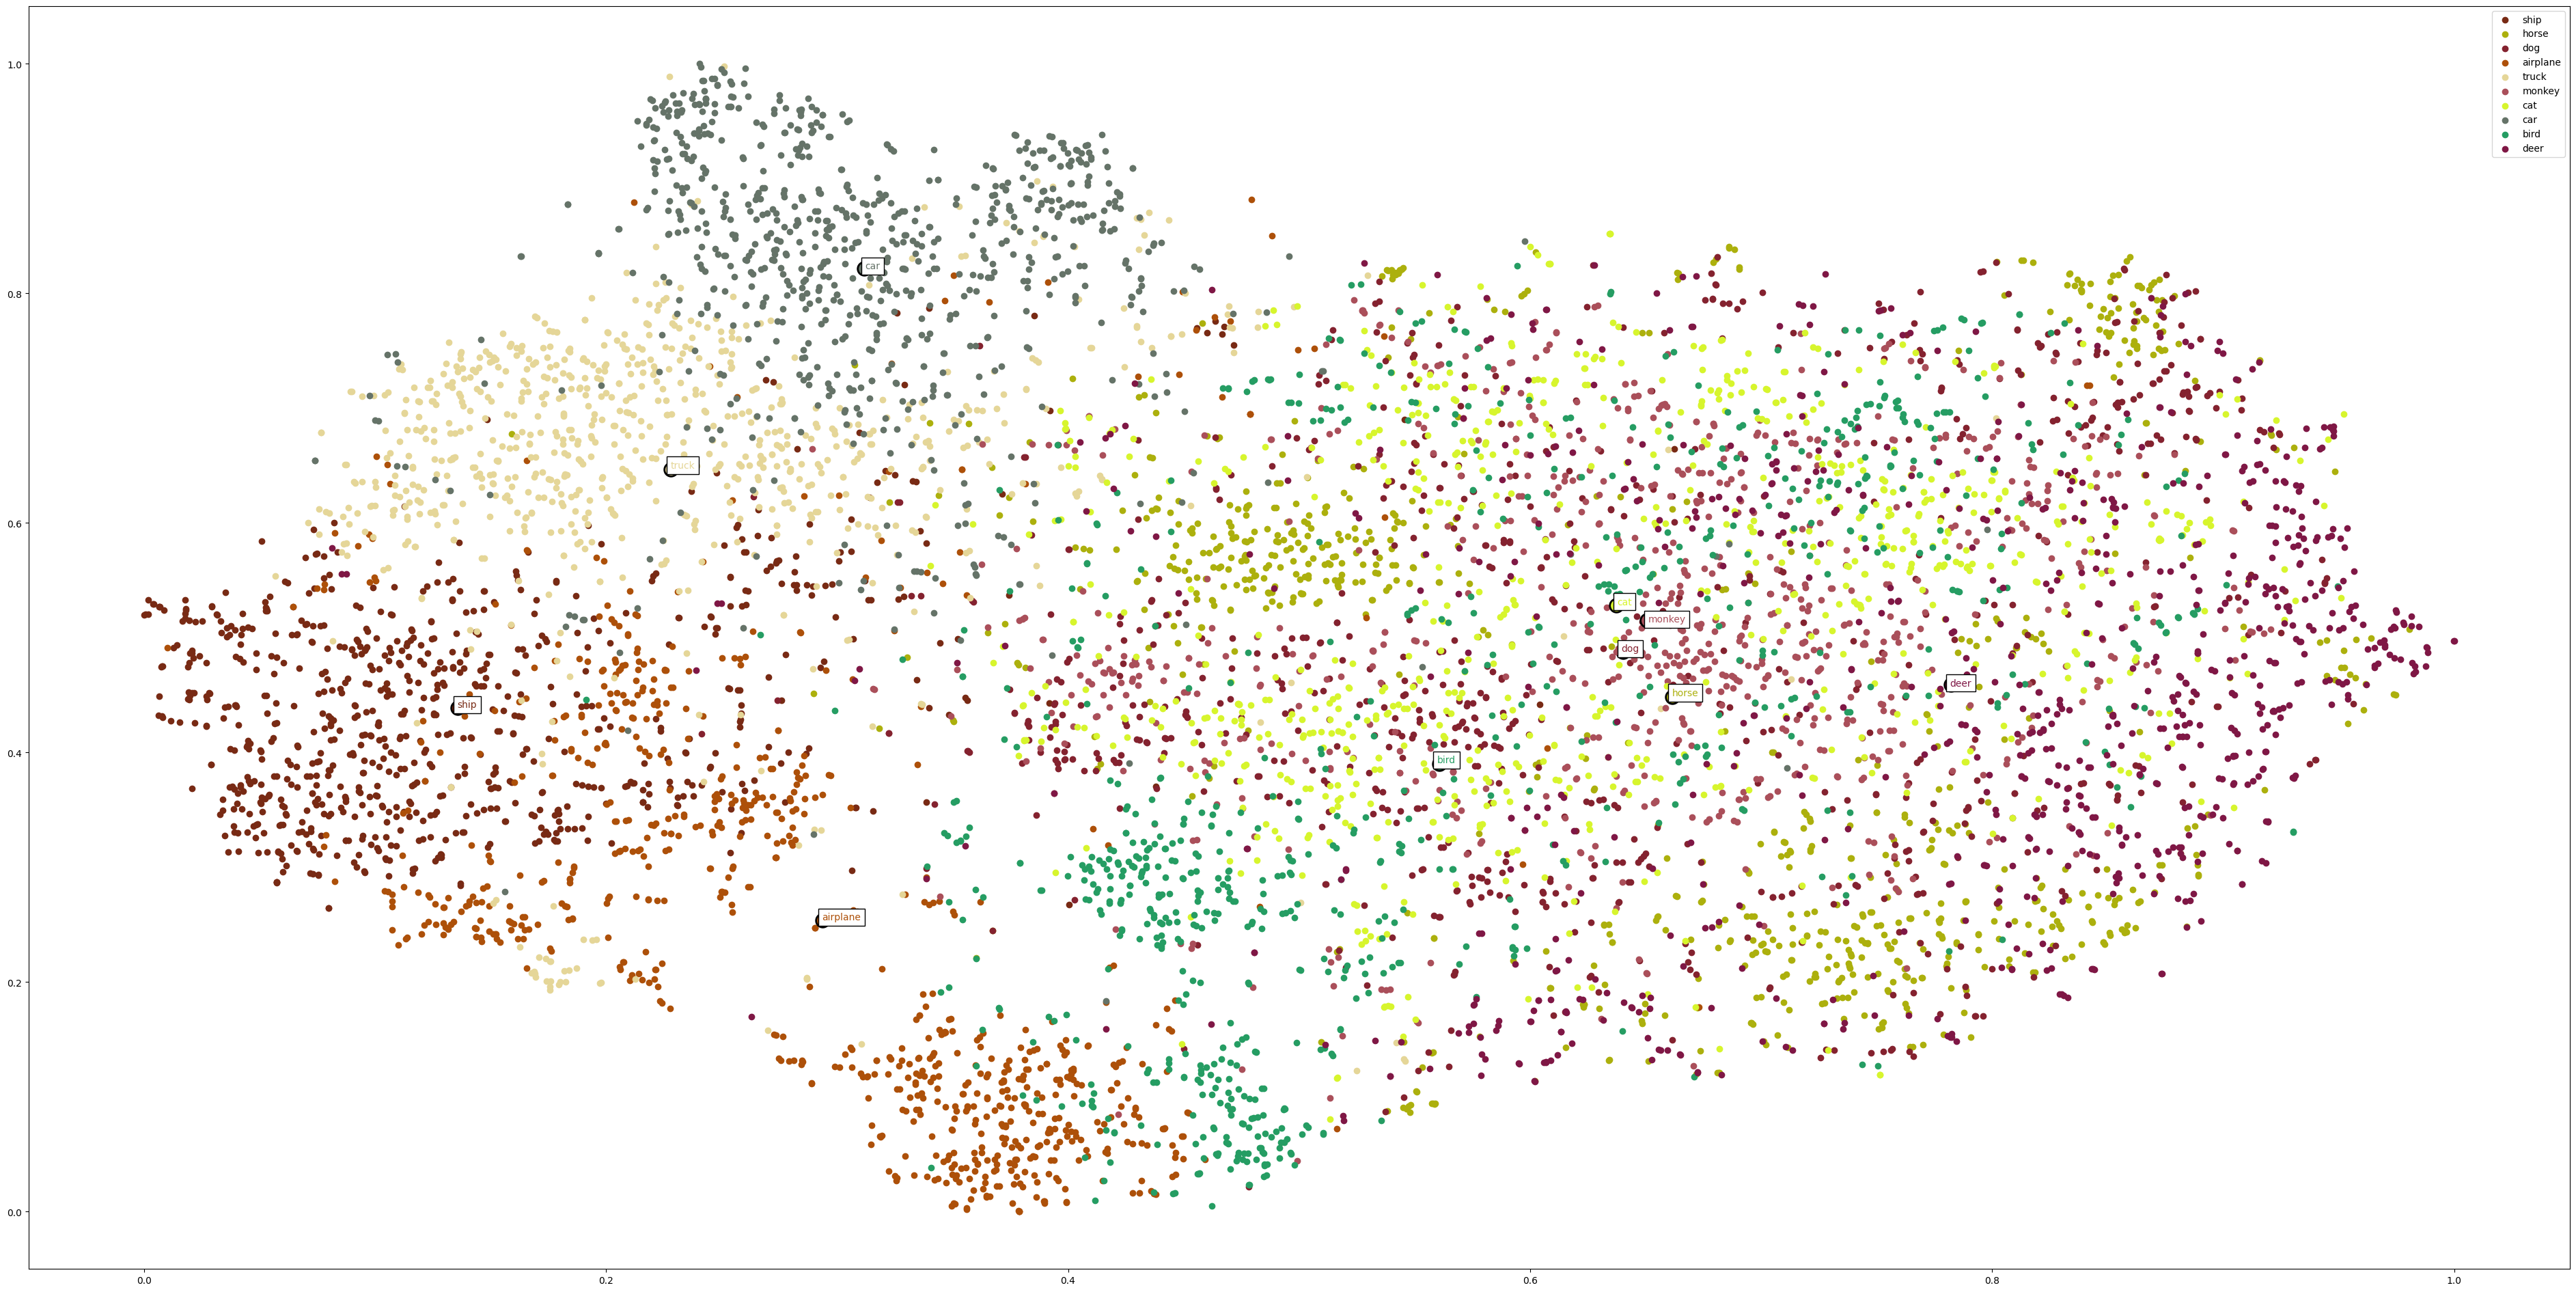

In [18]:

# initialize a matplotlib plot
fig = plt.figure(figsize=(48, 24))
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for c in classes:
    
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(_labels) if l == c]
    
    k = 2000 if len(indices) > 2000 else len(indices)
    sample = random.sample(indices, k=k)
    
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    X = np.stack((np.take(tx, indices), np.take(ty, indices)), axis=1)
    kmeans = KMeans(n_clusters=1).fit(X=X)
    centers = kmeans.cluster_centers_[0]
    
    # convert the class color to matplotlib format
    color = colors_per_class[c]
    name = val_dataset.labels[indices[0]]

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, color=color, label=name)

    shift_x = random.uniform(-0.001, 0.001)
    shift_y = random.uniform(-0.001, 0.001)
    ax.scatter([centers[0]], [centers[1]], edgecolors="k", linewidth=2, color=color, s=200, alpha=1)
    ax.text(x=centers[0]+shift_x, y=centers[1]+shift_y, s=f"{name}", fontdict=dict(color=color,size=10), bbox=dict(facecolor='white', alpha=1))
    


# build a legend using the labels we set previously
ax.legend(loc='best')

# finally, show the plot
plt.show()